# Defining and Training DummyRegression Model

In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#get stock data
df=pd.read_csv('/kaggle/input/nsei-prev-data/in_nsei_daily.csv',index_col='minute', parse_dates=True)
df.head()

,ticker,instrument_token,open,high,low,close
minute,,,,,,
2017-01-02 09:15:00+05:30,NSEI,uf-n-1647516806122,8211.70,8211.70,8134.30,8178.70
2017-01-03 09:15:00+05:30,NSEI,uf-n-1647516806122,8195.25,8219.00,8148.65,8188.60
2017-01-04 09:15:00+05:30,NSEI,uf-n-1647516806122,8201.60,8218.45,8180.95,8196.55
2017-01-05 09:15:00+05:30,NSEI,uf-n-1647516806122,8227.75,8282.55,8223.90,8269.90
2017-01-06 09:15:00+05:30,NSEI,uf-n-1647516806122,8283.50,8306.50,8233.45,8247.85


In [3]:
#change to datetime format
df.index = df.index.to_pydatetime()
df=pd.DataFrame(df)
df.shape

(1478, 6)

In [4]:
#check null entries
df.isnull().sum()

ticker              0
instrument_token    0
open                0
high                0
low                 0
close               0
dtype: int64

In [5]:
#check if any na
df.isna().any()

ticker              False
instrument_token    False
open                False
high                False
low                 False
close               False
dtype: bool

In [6]:
#define the feature columns and target column
features = ['open', 'high', 'low']
target = 'close'

In [7]:
#train/test split
x=df[features]
y=df[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [8]:
print(x_train.shape,x_test.shape)

(1034, 3) (444, 3)


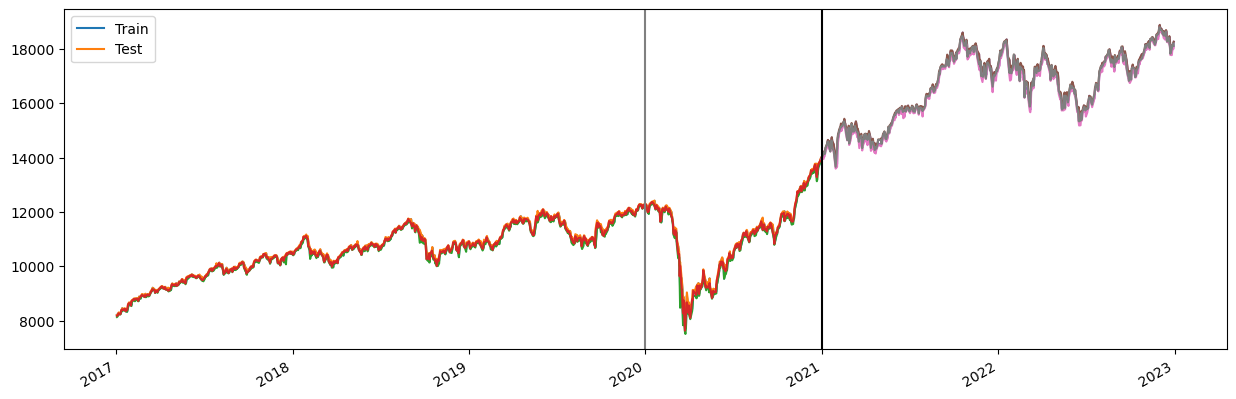

In [9]:
#train/test data plotting
train=df.loc[df.index<'01-01-2021']
test=df.loc[df.index>='31-12-2020']
train_=train.loc[train.index>'01-01-2020']
fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training Set')
test.plot(ax=ax,label='Test Set')
ax.axvline('01-01-2021',color='black')
ax.axvline('01-01-2020',color='grey')
ax.legend(['Train','Test'])
plt.show()

In [10]:
#get a dummy regressor that always predicts the mean of the target variable, and train on x and y data
#strategies: mean-good, median-bad, quantile-worse and constant-worsen
regressor= DummyRegressor(strategy='mean')
regressor.fit(x_train,y_train)

DummyRegressor()

In [11]:
#predict value against test
y_pred=regressor.predict(x_test)

In [12]:
#evaluate model's performance on train data
predict = regressor.predict(x_train)
r2 = r2_score(y_train, predict)
mse = mean_squared_error(y_train, predict)
rmse = mean_squared_error(y_train, predict, squared=False)
mae = mean_absolute_error(y_train, predict)
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

R2 Score: 0.0
Mean Squared Error: 8995836.526207065
Root Mean Squared Error: 2999.30600743023
Mean Absolute Error: 2634.3420834751896


In [13]:
#evaluate model's performance on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

R2 Score: -0.004816480674757262
Mean Squared Error: 9169058.035757743
Root Mean Squared Error: 3028.045249952144
Mean Absolute Error: 2628.83673981041


# Predict close price on test OHL(open, high, low)

In [14]:
#predictions for data
import pytz
y_pred=[]
index_ = test.index.tolist()
index_.insert(0, pd.Timestamp('2020-12-31 09:15:00+05:30', tz=pytz.FixedOffset(330)))
for i in range(1,len(index_)):
    regressor = DummyRegressor(strategy='mean')
    regressor.fit(train_[features],train_[target])
    y_pred.append(regressor.predict([test.loc[index_[i]][features]]))
    train_.loc[index_[i]] = test.loc[index_[i]]
    train_ = train_.iloc[1:]

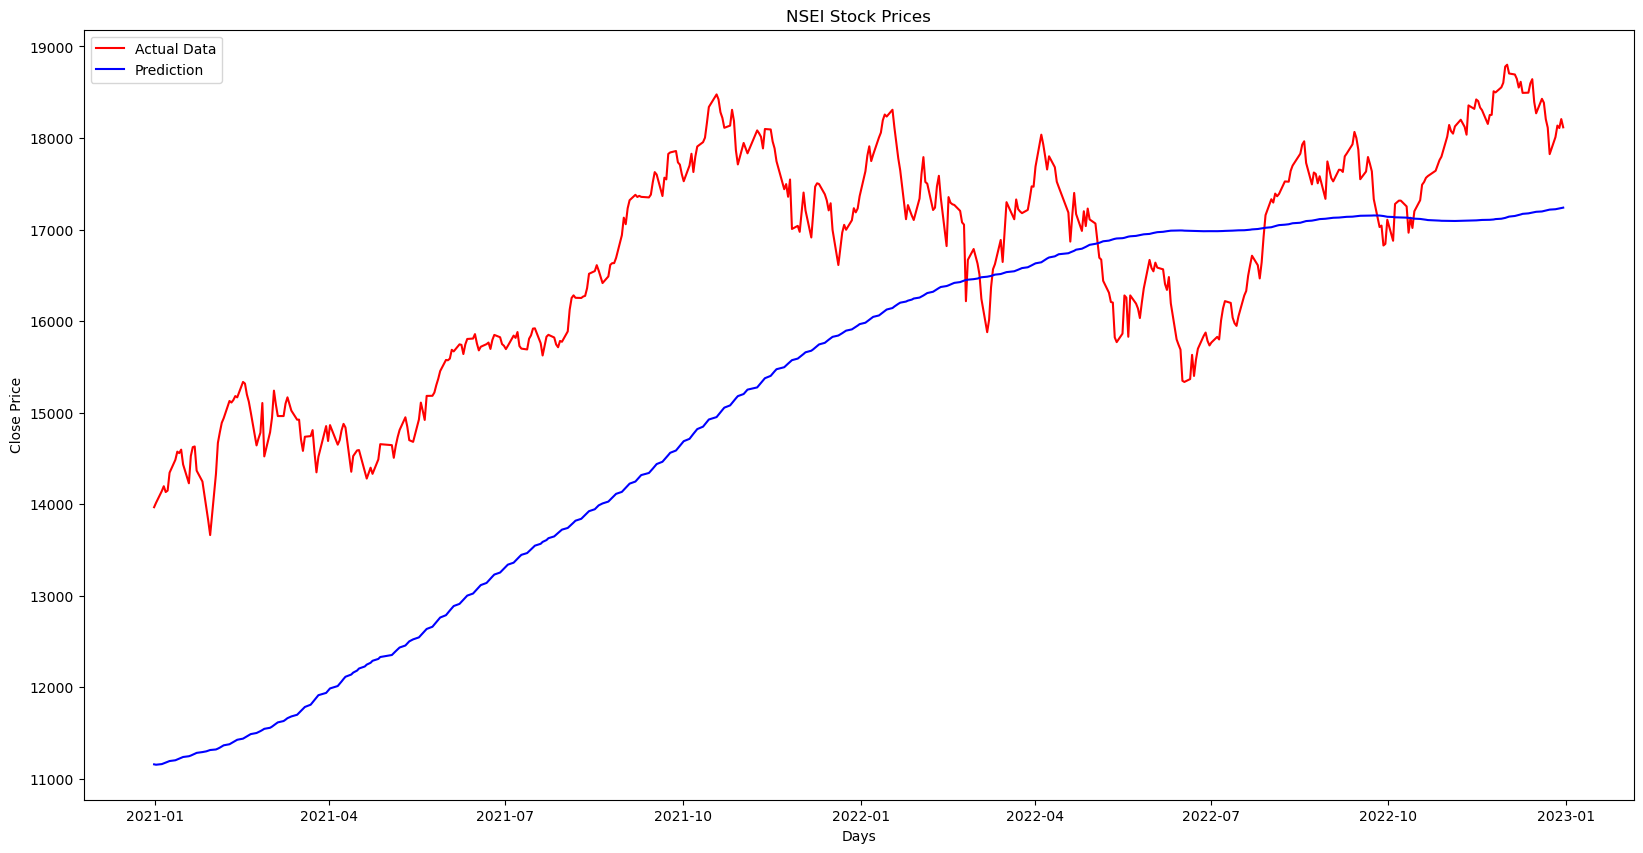

In [15]:
#plotting
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(test.index,test[target], color = 'red', label="Actual Data")
plt.plot(test.index,y_pred, color='blue', label="Prediction")

plt.title('NSEI Stock Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [16]:
#getting dataframe
import pytz
data_=[]
index_ = test.index.tolist()

try:
    for i in range(1,len(index_)):          
        if y_pred[i-1]<test[index_[i-1].strftime('%Y-%m-%d')].close[0]:
            direction='SELL'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': test[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': test[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': y_pred[i-1], 'Pnl':test[index_[i-1].strftime('%Y-%m-%d')].close[0]-test[index_[i].strftime('%Y-%m-%d')].close[0]})
        else:
            direction='BUY'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': test[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': test[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': y_pred[i-1], 'Pnl':test[index_[i].strftime('%Y-%m-%d')].close[0]-test[index_[i-1].strftime('%Y-%m-%d')].close[0]})

    
except KeyboardInterrupt or ValueError:
    print("Output is Stored in csv file: NSEI_STOCK.CSV!")

In [17]:
#storing in csv file
import csv
import os

headers = ['Date', 'Day', 'Current Close Price', 'Next Day Price','Predicted Direction', 'Predicted Value','Pnl']

if os.path.exists('/kaggle/working/nsei_stock.csv'):
    with open('nsei_stock.csv', mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        for row in data_:
            writer.writerow(row)
else:
    with open('nsei_stock.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        writer.writeheader()
        for row in data_:
            writer.writerow(row)

# Get Next Day Price

In [18]:
#install yfinance library that helps in stock data retrieval 
!pip install yfinance
import yfinance as yf
from time import time
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.1 MB/s eta 0:00:00


In [19]:
#to import NSEI stock data, set ticker symbol to ^NSEI
tickerSymbol = '^NSEI'
data = yf.Ticker(tickerSymbol)

In [20]:
#retrieve data from this day one year before to today
end_date = datetime.date.today() - datetime.timedelta(days=1)
start_date = end_date - datetime.timedelta(days=365)
day = datetime.date.today()
stock = data.history(start=start_date, end=end_date)

In [21]:
#last day open, high and low price
stock.iloc[-1][['Open','High','Low']]

Open    17427.949219
High    17428.050781
Low     17312.750000
Name: 2023-04-03 00:00:00+05:30, dtype: float64

In [22]:
def next_day_price(stock, day):
    x=stock[['Open','High','Low']]
    y=stock['Close']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    model = DummyRegressor(strategy='median')
    model.fit(x_train, y_train)
    predicted_price=model.predict([stock.iloc[-1][['Open','High','Low']]])
    print(f"Predicted price for the {day}:", predicted_price)

In [23]:
#predict price
next_day_price(stock,day)

Predicted price for the 2023-04-06: [17558.90039062]
